# Fully connected neural network

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import applications

## Arquitectura FCNN

In [3]:
input = layers.Input(shape=(320, 320, 3))
x = layers.Conv2D(64, 3, activation='relu', padding='same')(input)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, strides=2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, strides=2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, strides=2)(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, strides=2)(x)

In [4]:
model = keras.Model(input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 128)     147584    
                                                             

In [5]:
vgg16 = applications.VGG16(include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 1s 0us/step


In [6]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
output_channels=3

In [8]:
# Continuamos con el modelo
input = vgg16.input
out_vgg16 = vgg16.output
x = layers.Conv2D(output_channels, 7, activation='relu', padding='same')(out_vgg16)
conv1 = layers.Conv2DTranspose(output_channels, 4, strides=4, use_bias=False)(x)
x = layers.Conv2D(output_channels, 1, activation='relu', padding='same')(vgg16.get_layer('block4_pool').output)
pool2 = layers.Conv2DTranspose(output_channels, 2, strides=2, use_bias=False)(x)
pool3 = layers.Conv2D(output_channels, 1, activation='relu', padding='same')(vgg16.get_layer('block3_pool').output)
x = layers.Add()([pool2, pool3, conv1])
x = layers.Conv2DTranspose(output_channels, 8, strides=8, use_bias=False)(x)
x = layers.Softmax()(x)

In [9]:
model = keras.Model(input, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [10]:
for layer in vgg16.layers:
  layer.trainable=False

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

## Conjunto de datos

In [12]:
@tf.function
def load_img(data, train=True):
  img_input = tf.image.resize(data['image'],(224,224))
  mask_input = tf.image.resize(data['segmentation_mask'],(224,224))
  if train and np.random.uniform()>0.5:
    img_input = tf.image.flip_left_right(img_input)
    mask_input = tf.image.flip_left_right(mask_input)
  img_input, mask_input = tf.cast(img_input, tf.float32)/255.0, mask_input-1
  return img_input, mask_input

In [13]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0MS1MO/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0MS1MO/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [14]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [15]:
batch_size = 32
val_splits = 5
buffer_size = 100

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [21]:
train_dataset = dataset['train'].map(load_img, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = dataset['test'].map(lambda x: load_img(x, train=False), num_parallel_calls=AUTOTUNE).batch(batch_size)

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [69]:
history = model.fit(train_dataset, epochs=25)

Epoch 1/25
115/115 [==============================] - 20s 168ms/step - loss: 0.3851 - acc: 0.8355
Epoch 2/25
115/115 [==============================] - 20s 167ms/step - loss: 0.3768 - acc: 0.8398
Epoch 3/25
115/115 [==============================] - 20s 168ms/step - loss: 0.3707 - acc: 0.8429
Epoch 4/25
115/115 [==============================] - 20s 174ms/step - loss: 0.3652 - acc: 0.8457
Epoch 5/25
115/115 [==============================] - 23s 196ms/step - loss: 0.3621 - acc: 0.8475
Epoch 6/25
115/115 [==============================] - 22s 185ms/step - loss: 0.3571 - acc: 0.8499
Epoch 7/25
115/115 [==============================] - 24s 201ms/step - loss: 0.3534 - acc: 0.8515
Epoch 8/25
115/115 [==============================] - 23s 194ms/step - loss: 0.3500 - acc: 0.8532
Epoch 9/25
115/115 [==============================] - 23s 192ms/step - loss: 0.3477 - acc: 0.8543
Epoch 10/25
115/115 [==============================] - 22s 184ms/step - loss: 0.3456 - acc: 0.8552
Epoch 11/25


KeyboardInterrupt: ignored

In [40]:
history = model.fit(train_dataset, epochs=25, validation_data=test_dataset,
                    validation_steps=5, validation_batch_size=32)

Epoch 1/25
115/115 [==============================] - ETA: 0s - loss: 0.3926 - acc: 0.8314

ValueError: ignored

## Interpretamos los resultados

In [44]:
import cv2 as cv
from PIL import Image

In [73]:
def process_mask(mask):
  mask = (mask.numpy() * 127.5).astype('uint8')
  mask = cv.cvtColor(mask, cv.COLOR_GRAY2RGB)
  return mask

In [77]:
def segment(img_path):
  img = Image.open(img_path).resize((224,224))
  img0 = np.array(img).reshape((1, 224,224,-1))
  img = tf.cast(img0, tf.float32)/255.0
  mask = model.predict(img)
  mask = tf.argmax(mask, axis=-1)
  mask = mask[...,tf.newaxis]
  mask = process_mask(mask[0])
  img_out = np.hstack([img0[0], mask])
  plt.imshow(img_out)
  plt.show()

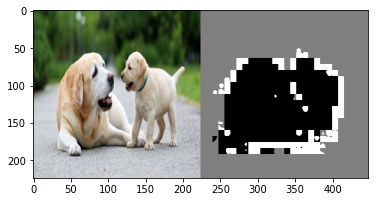

In [78]:
segment('/content/dogs3.jpg')

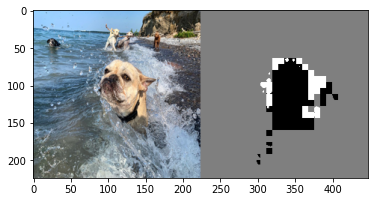

In [79]:
segment('/content/dogs2.jpg')

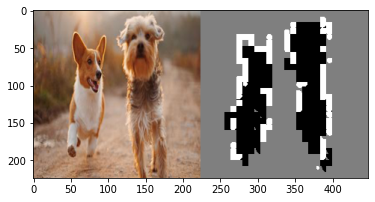

In [80]:
segment('/content/dogs.jpg')

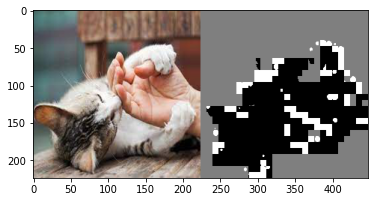

In [81]:
segment('cat.jpg')

In [82]:
!nvidia-smi

Sat Jul 16 23:01:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |   9256MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------